In [1]:
from DataProcessor import DataProcessor

# read in combined stock data
preprocessor = DataProcessor()

# create df to current date
data = preprocessor.process_nrw_data("06_09")


File already exists: processed_nrw_data/06_09_nrw_stock_data.csv. Loading DataFrame from file.


G:\My Drive\Master IS\Repos\webscraper\data_analysis\DataProcessor.py:140: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["store_availabilityInfo"] = df["store_availabilityInfo"].fillna(False)


In [3]:
# Identify product variants with at least 5 different stores
variant_store_counts = data.groupby(['id', 'store_skuId'])['store_storeId'].nunique()
variants_in_5_stores = variant_store_counts[variant_store_counts >= 5].index

# Filter the data for these variants
filtered_data = data[data.set_index(['id', 'store_skuId']).index.isin(variants_in_5_stores)].copy()

# Identify stock-out events (where store_quantity was > 0 and then became 0)
filtered_data['stock_out'] = filtered_data.groupby(['id', 'store_skuId', 'store_storeId'])['store_quantity'].transform(lambda x: (x.shift(1) > 0) & (x == 0))

# Identify variants with stock-out events in at least 2 stores
variant_stock_out_counts = filtered_data[filtered_data['stock_out']].groupby(['id', 'store_skuId'])['store_storeId'].nunique()
variants_with_stock_outs = variant_stock_out_counts[variant_stock_out_counts >= 2].index

# Filter the data for these variants
filtered_data_with_stock_outs = filtered_data[filtered_data.set_index(['id', 'store_skuId']).index.isin(variants_with_stock_outs)].copy()


C:\Users\felix\AppData\Local\Temp\ipykernel_15944\259817343.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  variant_store_counts = data.groupby(['id', 'store_skuId'])['store_storeId'].nunique()
C:\Users\felix\AppData\Local\Temp\ipykernel_15944\259817343.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_data['stock_out'] = filtered_data.groupby(['id', 'store_skuId', 'store_storeId'])['store_quantity'].transform(lambda x: (x.shift(1) > 0) & (x == 0))
C:\Users\felix\AppData\Local\Temp\ipykernel_15944\259817343.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to

In [12]:
# length of filtered data
len(filtered_data_with_stock_outs)
# print count of unique variants
len(filtered_data_with_stock_outs[['id', 'store_skuId']].drop_duplicates())

114

In [8]:
# Function to plot stock quantity over time for a given variant
import matplotlib.pyplot as plt

def plot_stock_quantity_over_time(variant_data, id, sku_id, product_name, sub_category):
    plt.figure(figsize=(10, 6))
    for store_name in variant_data['store_storeName'].unique():
        store_data = variant_data[variant_data['store_storeName'] == store_name]
        plt.plot(store_data['timestamp'], store_data['store_quantity'], label=store_name)
    
    plt.xlabel('Time')
    plt.ylabel('Stock Quantity')
    plt.title(f'Stock Quantity Over Time\nProduct: {product_name}\nSub-category: {sub_category}\nID: {id}, SKU ID: {sku_id}')
    plt.legend()
    plt.show()


C:\Users\felix\AppData\Local\Temp\ipykernel_15944\1918080064.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  variants_to_plot = filtered_data_with_stock_outs.groupby('sub_category').apply(lambda x: x.drop_duplicates(['id', 'store_skuId']).head(3)).reset_index(drop=True)
C:\Users\felix\AppData\Local\Temp\ipykernel_15944\1918080064.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  variants_to_plot = filtered_data_with_stock_outs.groupby('sub_category').apply(lambda x: x.drop_duplicates(['id', 'store_skuI

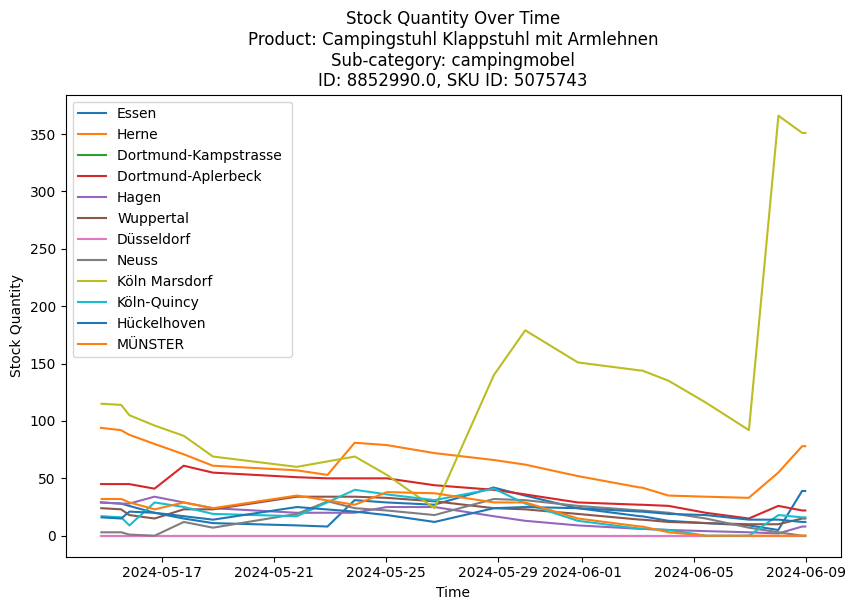

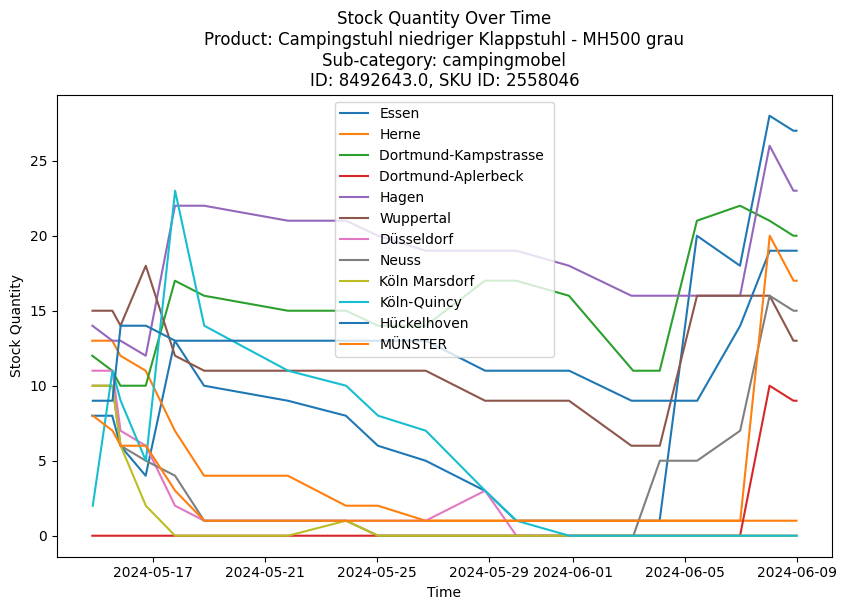

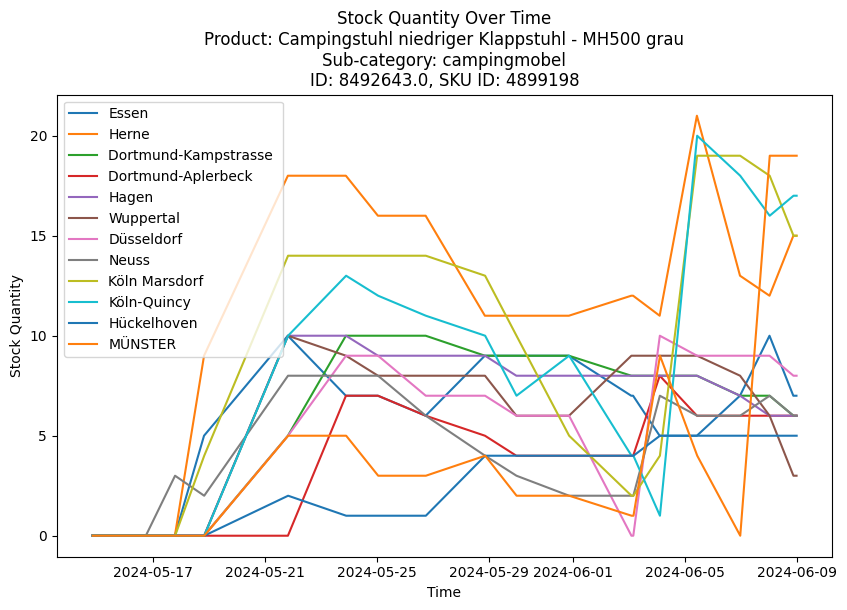

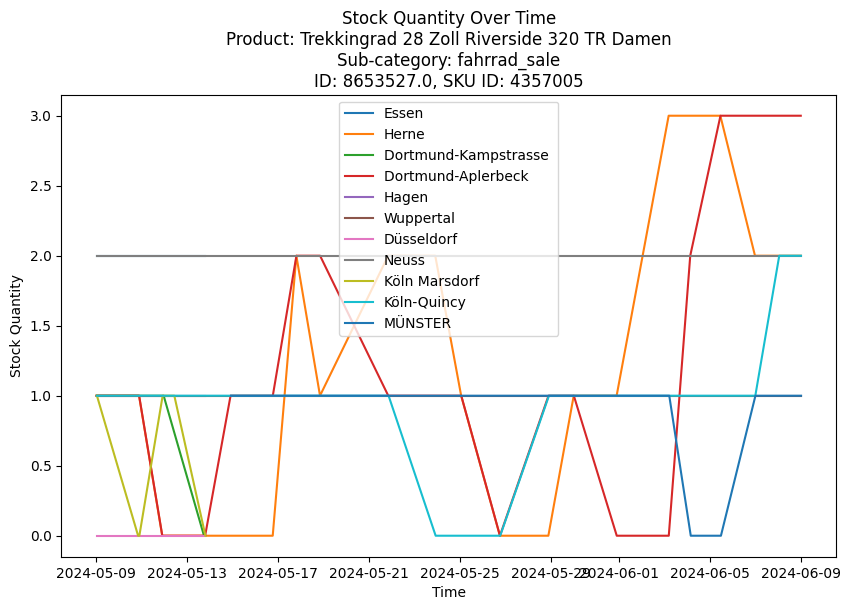

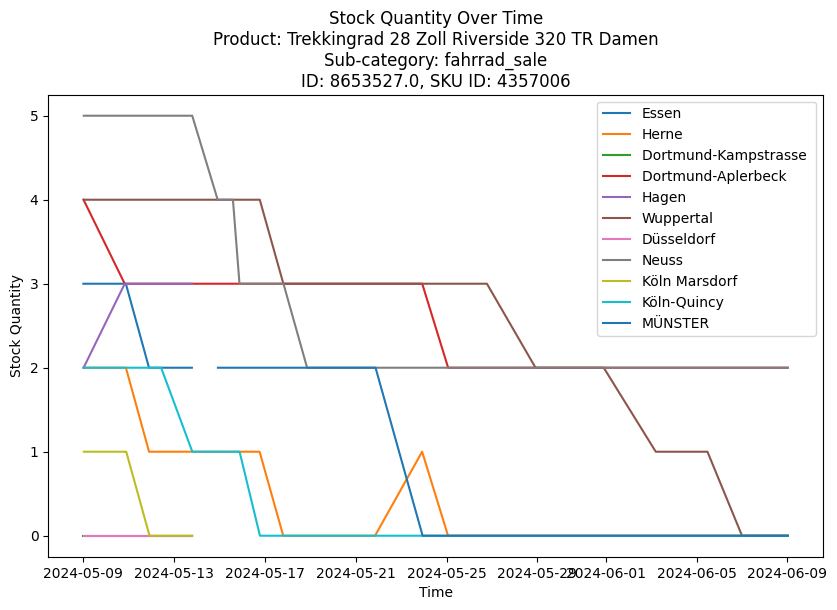

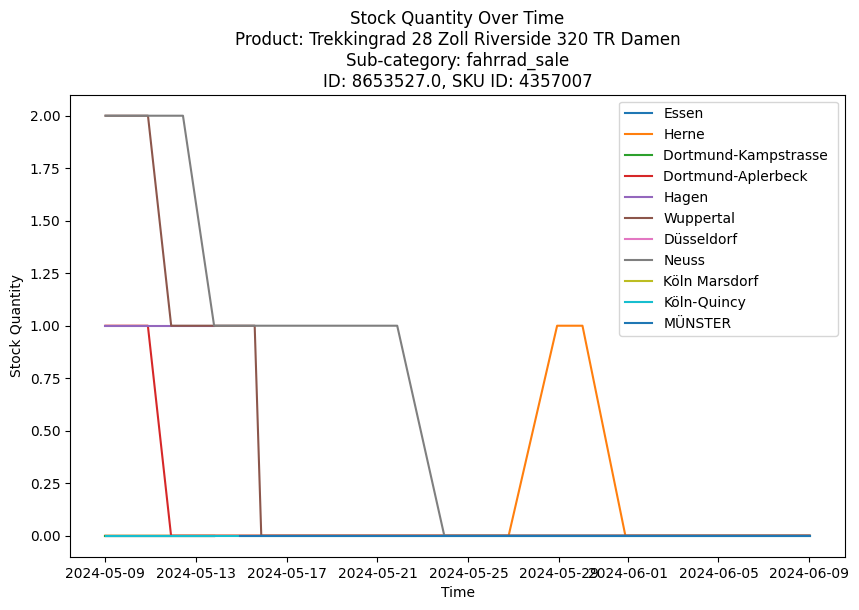

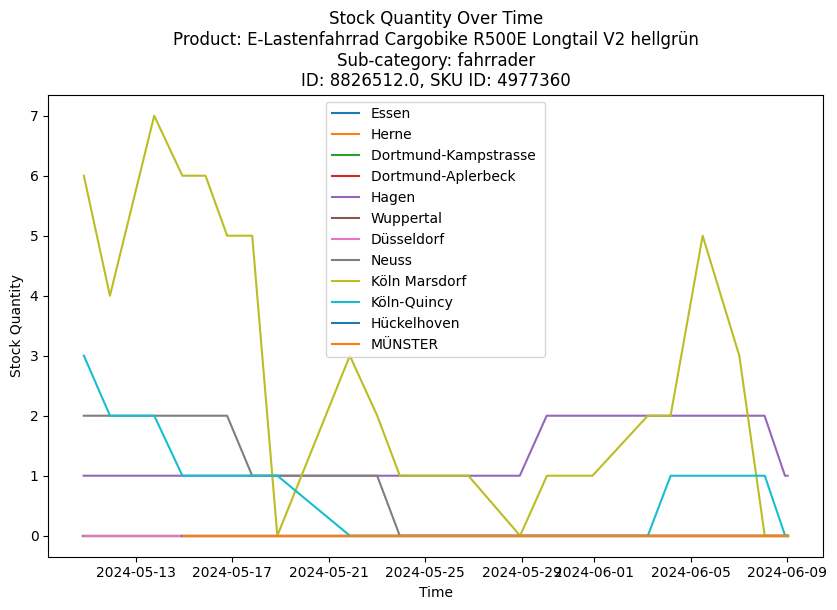

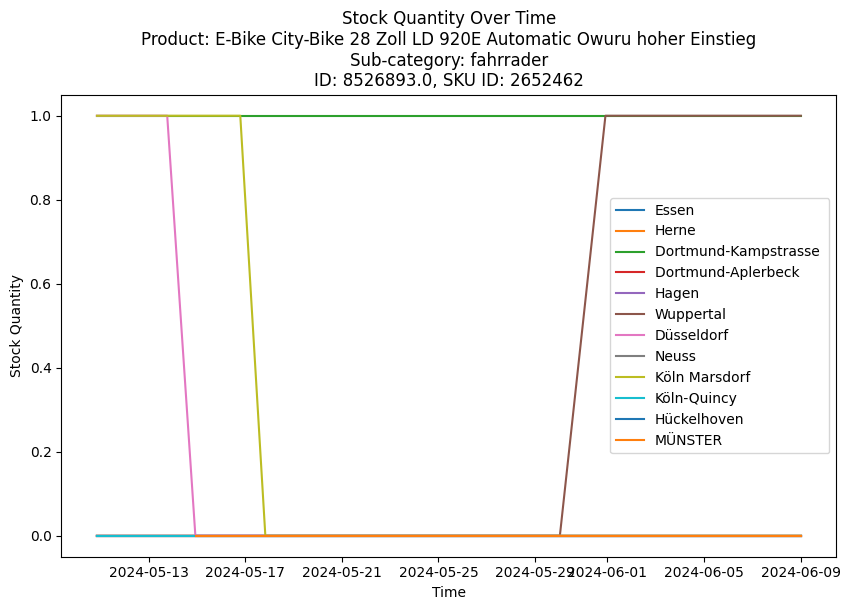

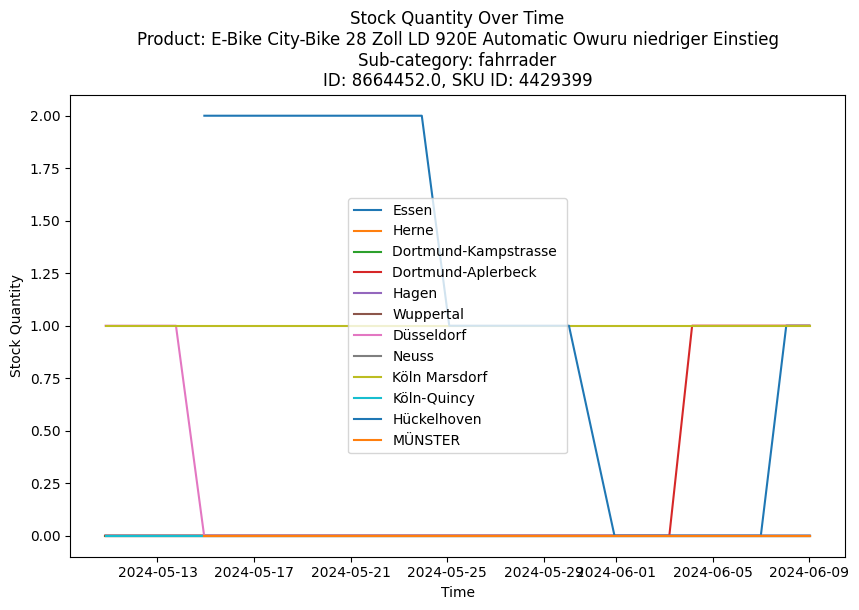

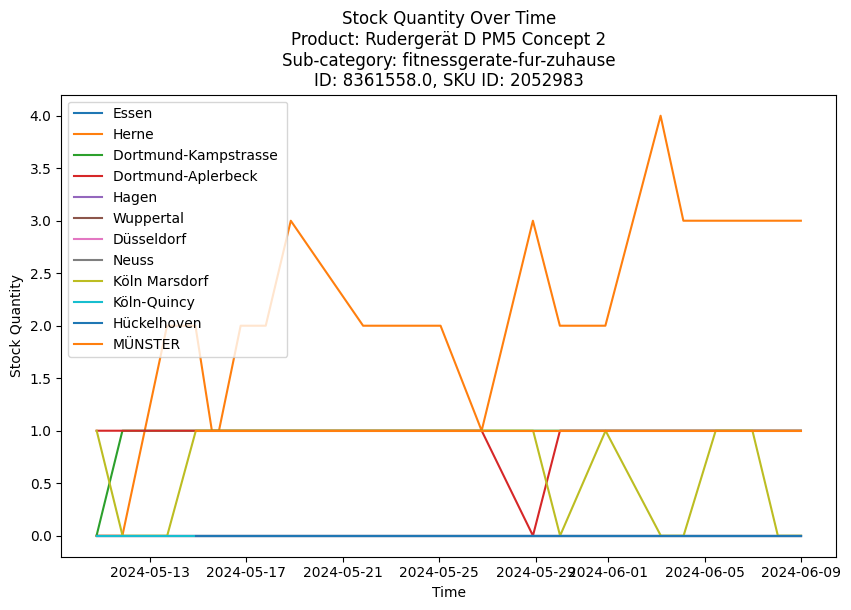

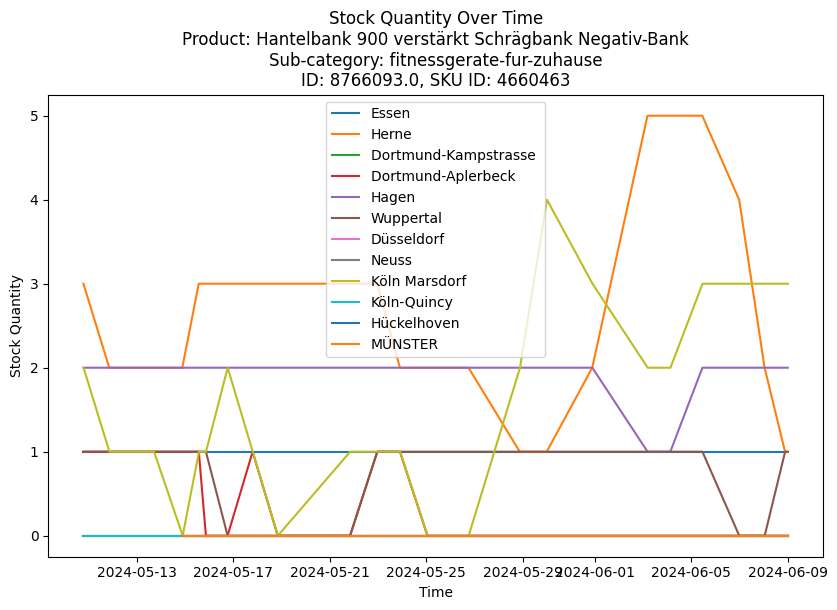

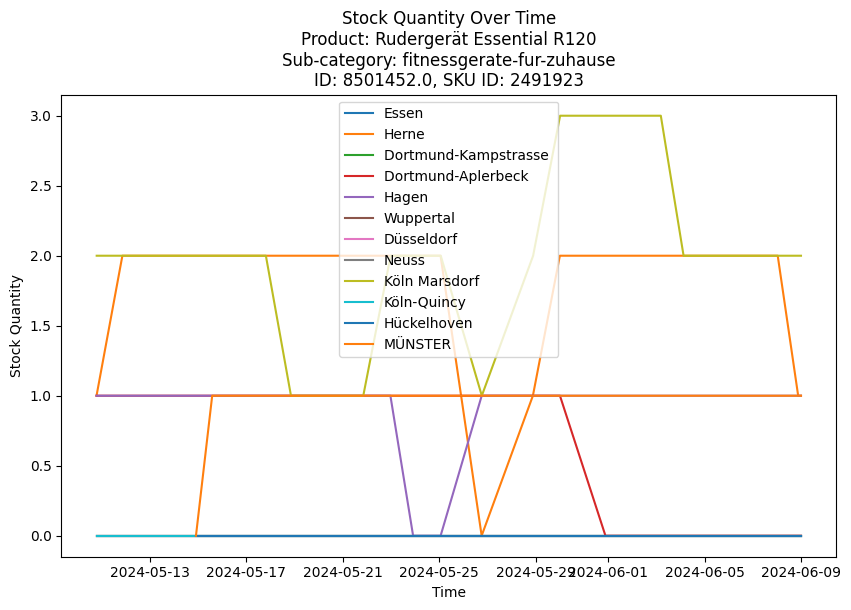

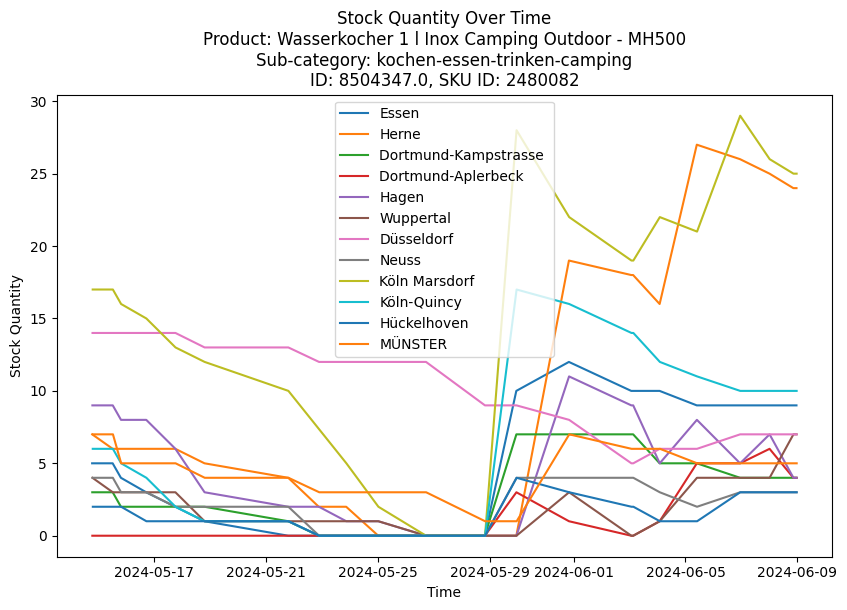

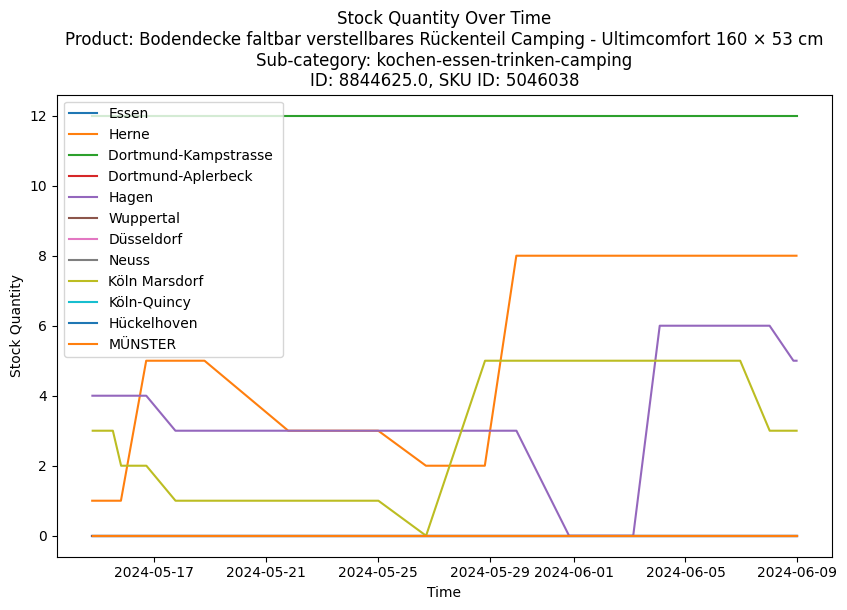

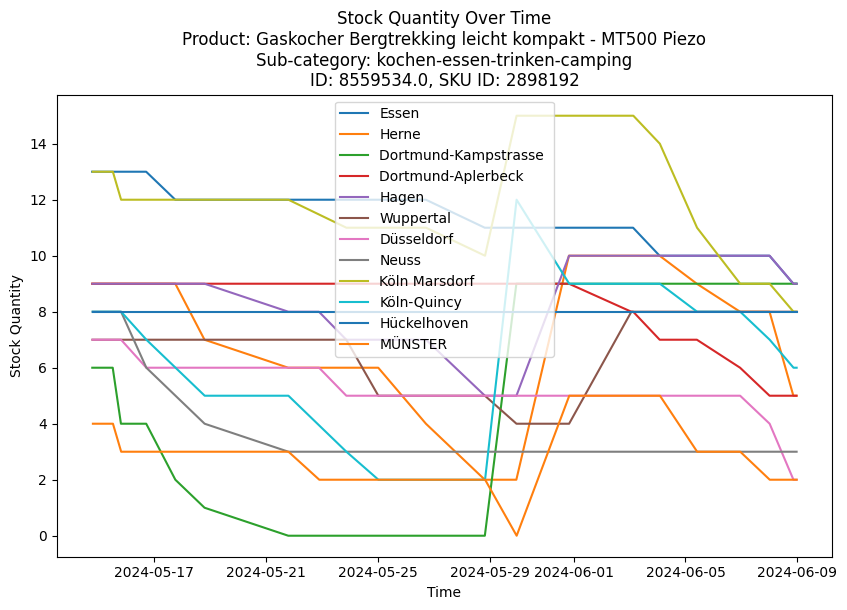

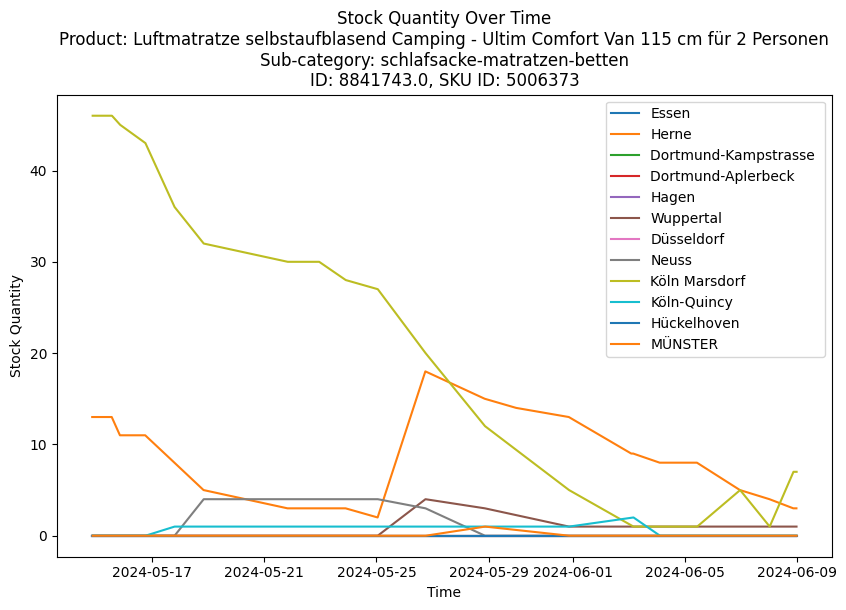

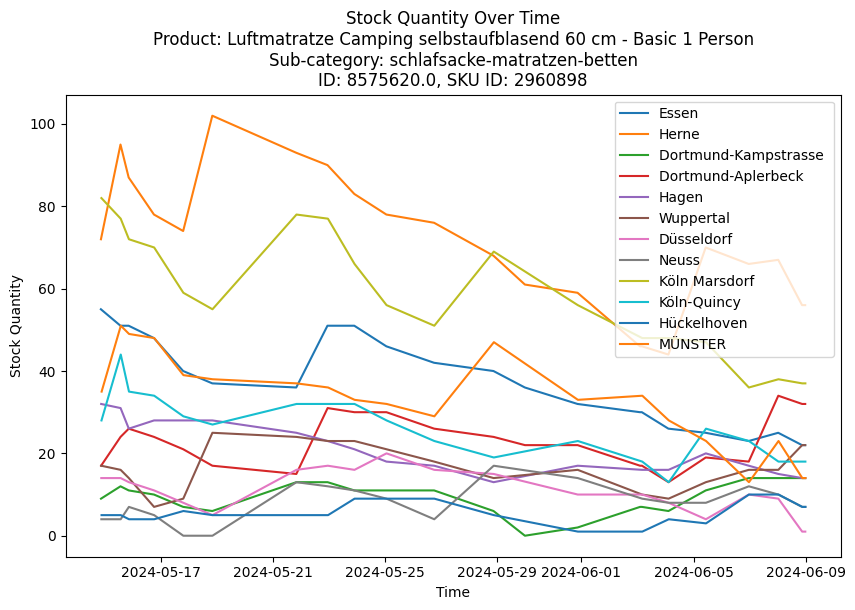

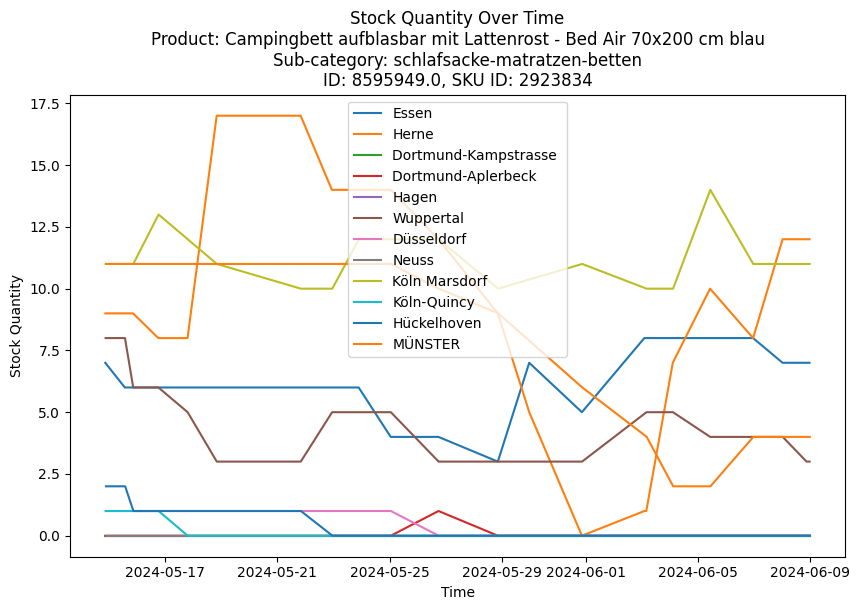

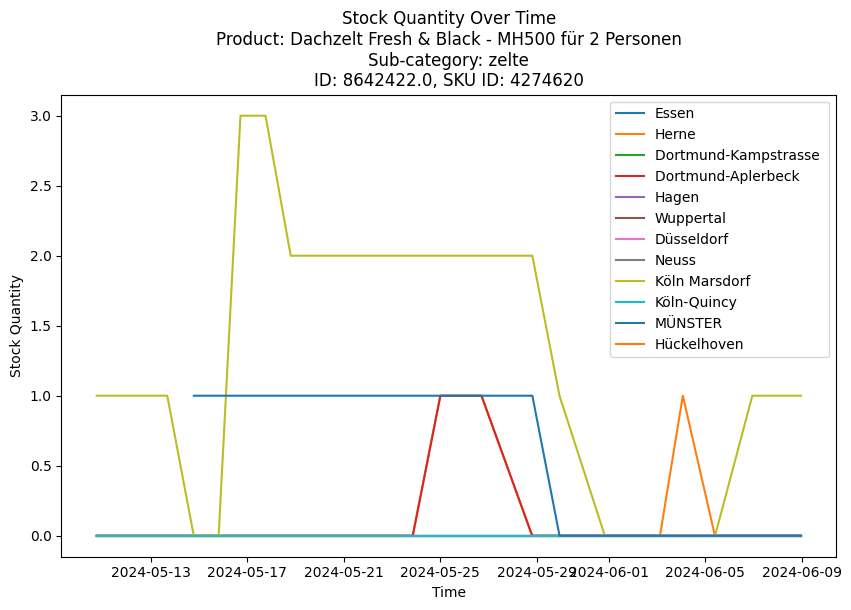

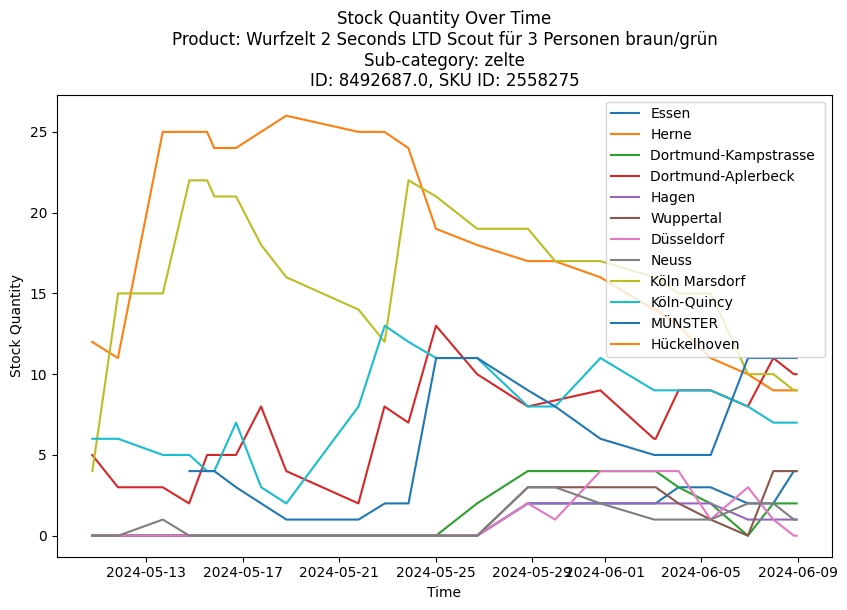

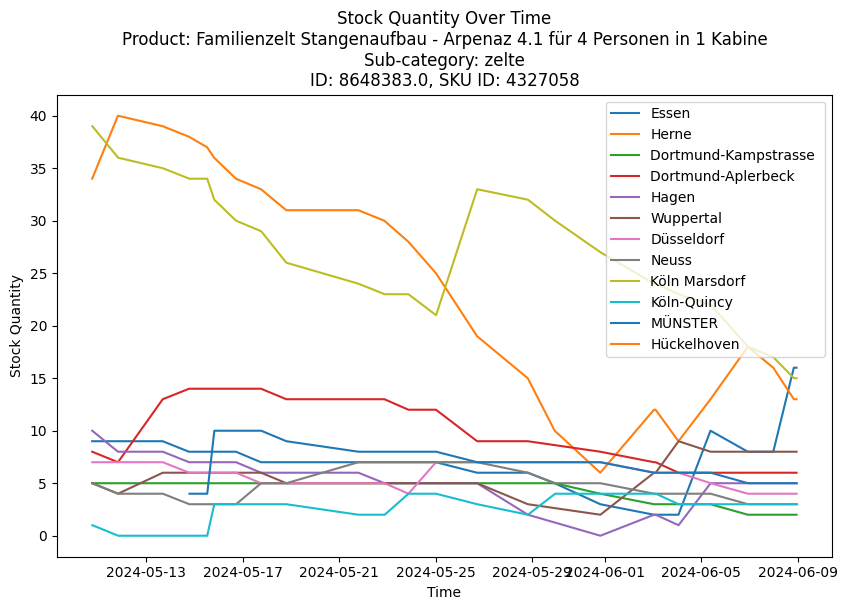

In [9]:
# Plot up to 3 variants per sub_category
variants_to_plot = filtered_data_with_stock_outs.groupby('sub_category').apply(lambda x: x.drop_duplicates(['id', 'store_skuId']).head(3)).reset_index(drop=True)

for _, variant in variants_to_plot.iterrows():
    variant_data = filtered_data_with_stock_outs[(filtered_data_with_stock_outs['id'] == variant['id']) & (filtered_data_with_stock_outs['store_skuId'] == variant['store_skuId'])]
    plot_stock_quantity_over_time(variant_data, variant['id'], variant['store_skuId'], variant['product_name'], variant['sub_category'])
